# Flights Delay Analysis

## Introduction
The data comes from [the U.S. Department of Transportation](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236), which publishes very large files each month that contain delay data on every flight flown by a major airline within the U.S. They cover about 500,000 flights per month, or about 6 million over the course of the past year. This analysis is based on the data from January 2016 to December 2016.

Data field name and desciption : 
- `YEAR` — Year
- `QUARTER` — Quarter (1-4)
- `MONTH` — Month
- `DAY_OF_MONTH` — Day of Month
- `DAY_OF_WEEK` — Day of Week
- `FL_DATE`— Flight Date (yyyy-mm-dd)
- `UNIQUE_CARRIER` — Unique Carrier Code. (`HA`:	Hawaiian Airlines Inc., `AS`:	Alaska Airlines Inc., `DL`:	Delta Air Lines Inc., `OO`:	SkyWest Airlines Inc., `UA`:	United Air Lines Inc., `EV`:	ExpressJet Airlines Inc., `WN`:	Southwest Airlines Co., `AA`:	American Airlines Inc., `VX`:	Virgin America, `F9`:	Frontier Airlines Inc., `B6`:	JetBlue Airways, `NK`:	Spirit Air Lines.)
- `ORIGIN`— Origin Airport
- `ORIGIN_CITY_NAME` — Origin Airport, City Name
- `DEST` — Destination Airport
- `DEST_CITY_NAME` — Destination Airport, City Name
- `CRS_DEP_TIME` — CRS Departure Time (local time: hhmm)
- `DEP_TIME` — Actual Departure Time (local time: hhmm)
- `DEP_DEL15` — Departure Delay Indicator, 15 Minutes or More (1=Yes)
- `CRS_ARR_TIME` — CRS Arrival Time (local time: hhmm)
- `ARR_TIME` — Actual Arrival Time (local time: hhmm)
- `ARR_DEL15` — Arrival Delay Indicator, 15 Minutes or More (1=Yes)
- `FLIGHTS` — Number of Flights
- `DISTANCE` — Distance between airports (miles)
- `DISTANCE_GROUP` — Distance Intervals, every 250 Miles, for Flight Segment

In [1]:
# import lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load the data
delay = pd.read_csv("delay16.csv")
delay.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,FLIGHTS,DISTANCE,DISTANCE_GROUP
0,2016,1,1,3,7,2016-01-03,F9,DEN,"Denver, CO",CID,"Cedar Rapids/Iowa City, IA",1525,1524,0,1820,1815,0,1,692,3
1,2016,1,1,3,7,2016-01-03,F9,PBI,"West Palm Beach/Palm Beach, FL",DEN,"Denver, CO",700,744,1,929,948,1,1,1679,7
2,2016,1,1,3,7,2016-01-03,F9,TTN,"Trenton, NJ",RDU,"Raleigh/Durham, NC",1845,1858,0,2015,2013,0,1,373,2
3,2016,1,1,3,7,2016-01-03,F9,RDU,"Raleigh/Durham, NC",TTN,"Trenton, NJ",2055,2054,0,2220,2215,0,1,373,2
4,2016,1,1,3,7,2016-01-03,F9,TTN,"Trenton, NJ",ORD,"Chicago, IL",1250,1252,0,1420,1440,1,1,693,3


In [3]:
# Create delay Column
delay.loc[:, "OTP"] = 0

# filter 
filter_Delay = (delay["DEP_DEL15"] == 1) | (delay["ARR_DEL15"] == 1) 
filter_DnA =  (delay["DEP_DEL15"] == 1) & (delay["ARR_DEL15"] == 0) 

# apply delay filter to DEL15
delay.loc[filter_Delay, "OTP"] = 1

In [4]:
# Function to create graph
def plotDelay(x, data, ax, xlab, hue=None, xticklabs=None, top=0):
    sns.countplot(x=x, data=data, ax=ax, hue=hue)
    total = len(data)
    #annotation
    ymax = 0
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, (p.get_height() - top), int(p.get_height()), color="w", fontweight="ultralight", ha="center", va="center", alpha=0.3)
        ax.text(p.get_x()+p.get_width()/2, p.get_height()/2, "{0} %".format(round((p.get_height() * 100) / total), 2), color="w", fontweight="bold", ha="center", va="center")
        if ymax < p.get_height():
            ymax = p.get_height()

    #settings
    ax.tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
    ax.set_yticks([]) #show only the extreme value
    if(xticklabs != None):
        ax.set_xticklabels(xticklabs) #rename the xticklabels
    ax.set_ylabel("") #hiding the "count" label
    ax.set_xlabel(xlab) #x label
    sns.despine(left=True, bottom=True) #hiding axes left/right/top/bottom

## Visualizations

### The Number of Delays Per Types

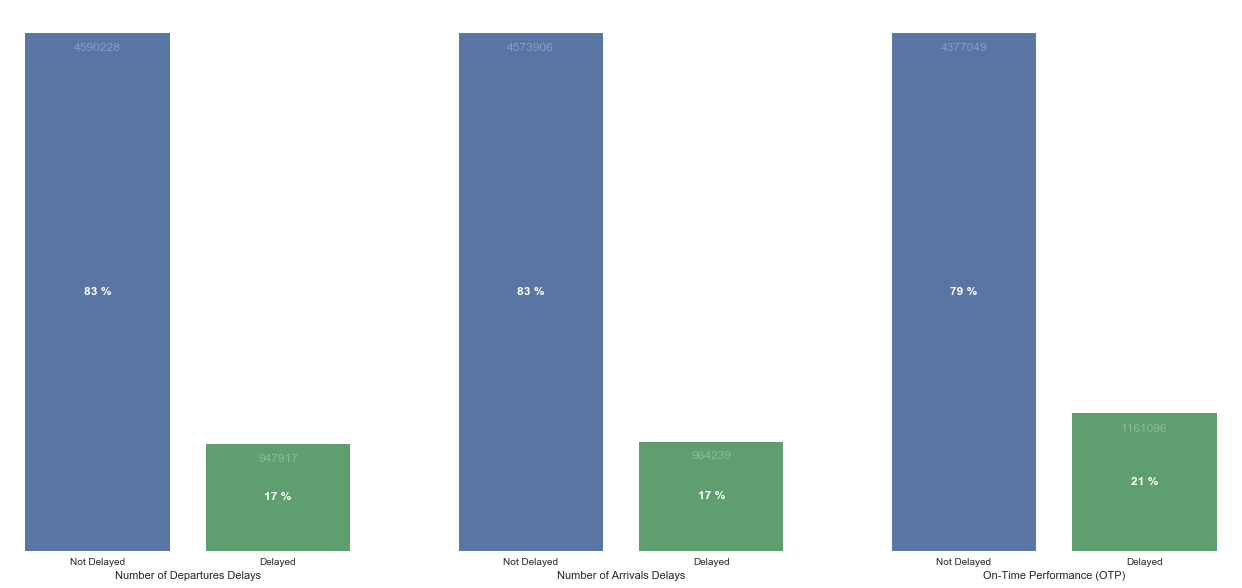

In [5]:
sns.set(style="white")

fig, ax = plt.subplots(1,3, figsize=(22,10))

plotDelay(x="DEP_DEL15", data=delay, ax=ax[0], top=130000, 
          xlab="Number of Departures Delays", xticklabs=["Not Delayed","Delayed"])
plotDelay(x="ARR_DEL15", data=delay, ax=ax[1], top=130000, 
          xlab="Number of Arrivals Delays", xticklabs=["Not Delayed","Delayed"])
plotDelay(x="OTP", data=delay, ax=ax[2], top=130000, 
          xlab="On-Time Performance (OTP)", xticklabs=["Not Delayed","Delayed"])

In [6]:
# The on-time arrival performance knowing that departure has been delayed
round((len(delay[filter_DnA]) * 100) / len(delay[delay["DEP_DEL15"] == 1]), 2)

20.77

*Note : The on-time performance (OTP) is a flight that arrives or departs within 15 minutes.*

**Obviously, the departures delayed and arrivals delayed are correlated. Only 21% of flights delayed on departure arrived on time. In this project, we will rather analyze arrival delays as this is what concerns most passengers.**

## Daily Analysis
### Delays Per Day of Week

In [7]:
delay_by_days = delay.groupby(by="DAY_OF_WEEK")["ARR_DEL15"].agg(["sum", "count"])
delay_by_days.loc[:,"percent"] = (delay_by_days["sum"] * 100) / delay_by_days["count"]

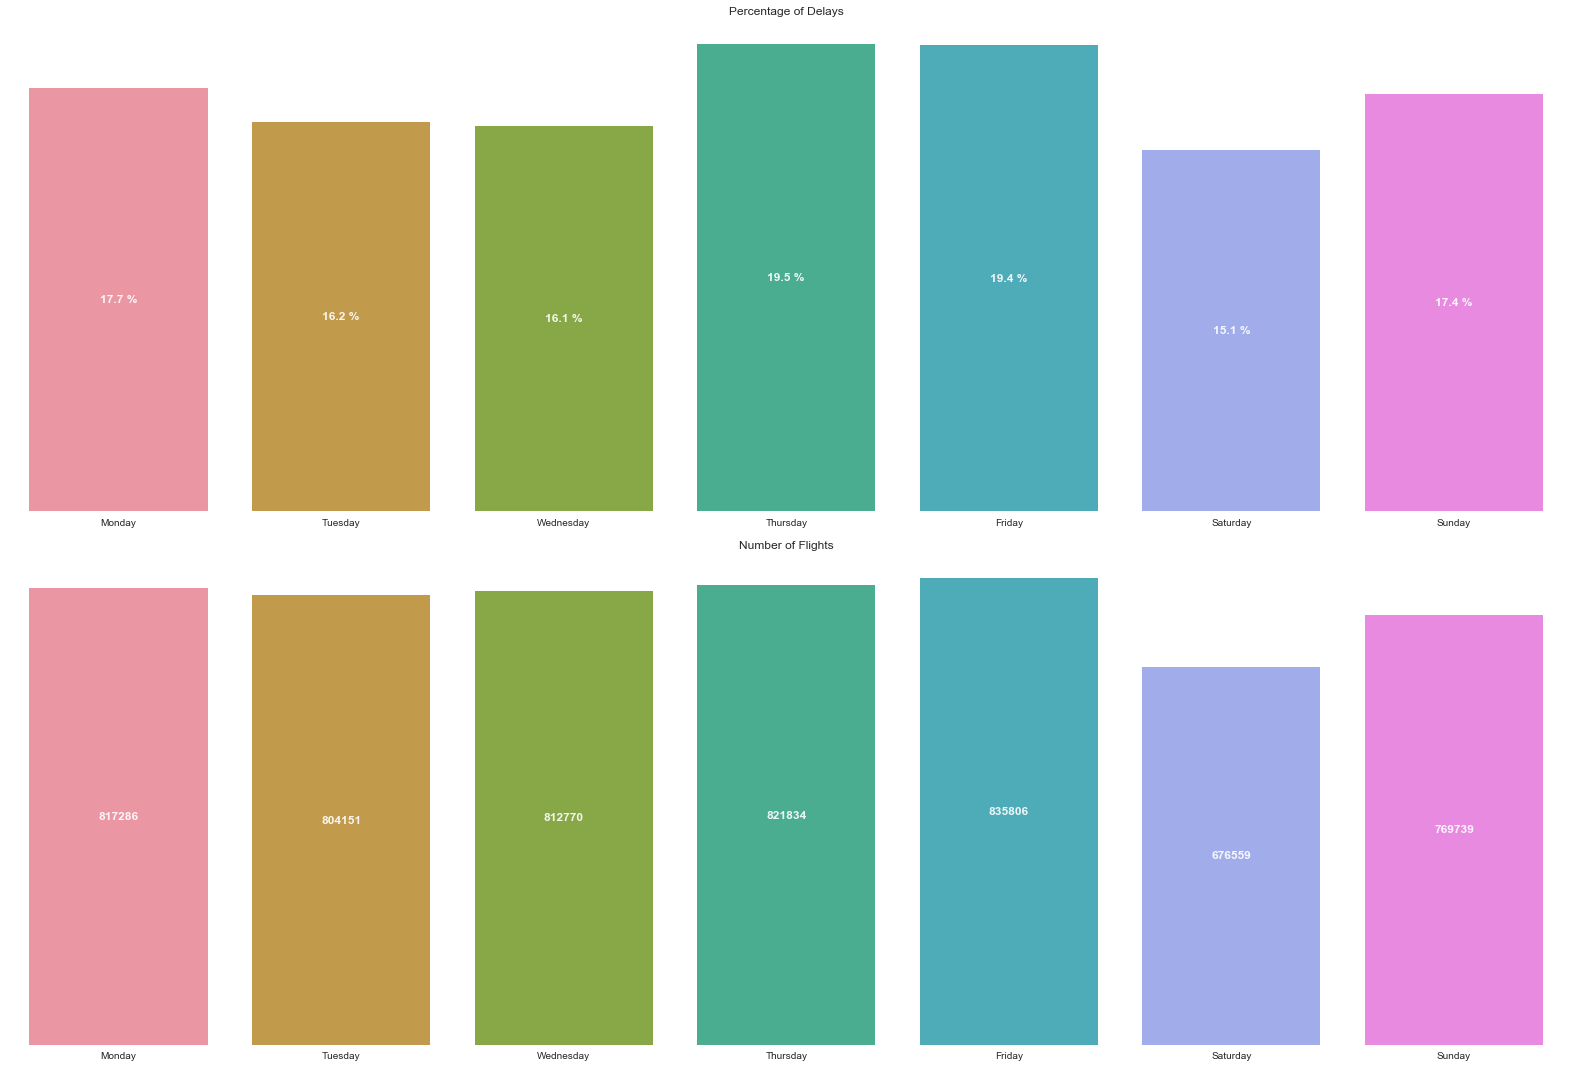

In [8]:
fig, ax = plt.subplots(2,1, figsize=(22,15))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=delay_by_days.index, y=delay_by_days["percent"], ax=ax[0])
sns.countplot(x=delay["DAY_OF_WEEK"], ax=ax[1])
# Annotations
for p in ax[0].patches:
        ax[0].text(p.get_x()+p.get_width()/2, (p.get_height()/2), "{0} %".format(round(p.get_height(),1)), 
                color="w", fontweight="bold", ha="center", va="center", alpha=0.9)
ax[0].tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
ax[0].set_yticks([]) #show only the extreme value
ax[0].set_xticklabels(days)
ax[0].set_ylabel("") #hiding the "count" label
ax[0].set_xlabel("") #x label
ax[0].set_title("Percentage of Delays")

for p in ax[1].patches:
        ax[1].text(p.get_x()+p.get_width()/2, (p.get_height()/2), int(p.get_height()), 
                color="w", fontweight="bold", ha="center", va="center", alpha=0.9)
ax[1].tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
ax[1].set_yticks([]) #show only the extreme value
ax[1].set_xticklabels(days)
ax[1].set_ylabel("") #hiding the "count" label
ax[1].set_xlabel("") #x label
ax[1].set_title("Number of Flights")

sns.despine(left=True, bottom=True)
plt.tight_layout()

fig.savefig("DayOfWeek_delays.png", transparent=True, bbox_inches='tight', pad_inches=0)

**In term of delays, the best day to fly seems to be Saturday (15% of delays), the worst days are Thursday and Friday (19% of delays). Saturday has fewer flights on average than any other day of the week and therefore a reduction in the likelihood of delays, but it's difficult to see a pattern here.**

### Delays Per Day of Month

In [9]:
delay_by_dmonth = delay.groupby(by="DAY_OF_MONTH")["ARR_DEL15"].agg(["sum", "count"])
delay_by_dmonth.loc[:,"percent"] = (delay_by_dmonth["sum"] * 100) / delay_by_dmonth["count"]

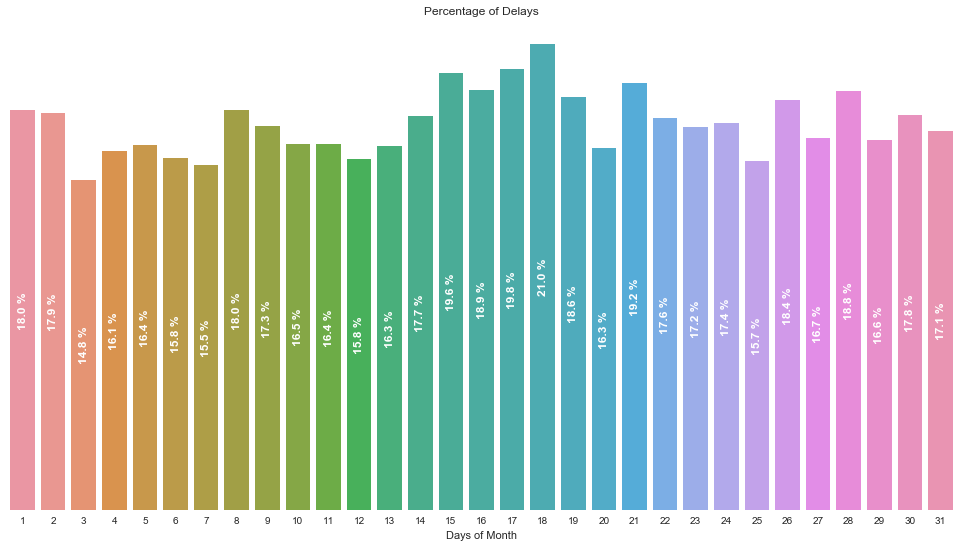

In [10]:
fig, ax = plt.subplots(1,1, figsize=(17,9))
sns.barplot(x=delay_by_dmonth.index, y=delay_by_dmonth["percent"])

# Annotations
for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, (p.get_height()/2), "{0} %".format(round(p.get_height(),1)), 
                color="w", fontweight="bold", ha="center", va="center", alpha=1, rotation="vertical")
ax.tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
ax.set_yticks([]) #show only the extreme value
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("Days of Month") #x label
ax.set_title("Percentage of Delays")
sns.despine(left=True, bottom=True)

### Delay By Hour of day

In [11]:
def getHr(x):
    x = str(x)
    if len(x) == 4:
        return int(x[:2])
    if len(x) == 3:
        return int(x[:1])
    if len(x) < 3:
        return int(0)
    
delay["HR_DEP_TIME"] = delay["CRS_DEP_TIME"].apply(getHr)

In [12]:
delay_by_hour = delay.groupby(by="HR_DEP_TIME")["ARR_DEL15"].agg(["sum", "count"])
delay_by_hour.loc[:,"percent"] = (delay_by_hour["sum"] * 100) / delay_by_hour["count"]

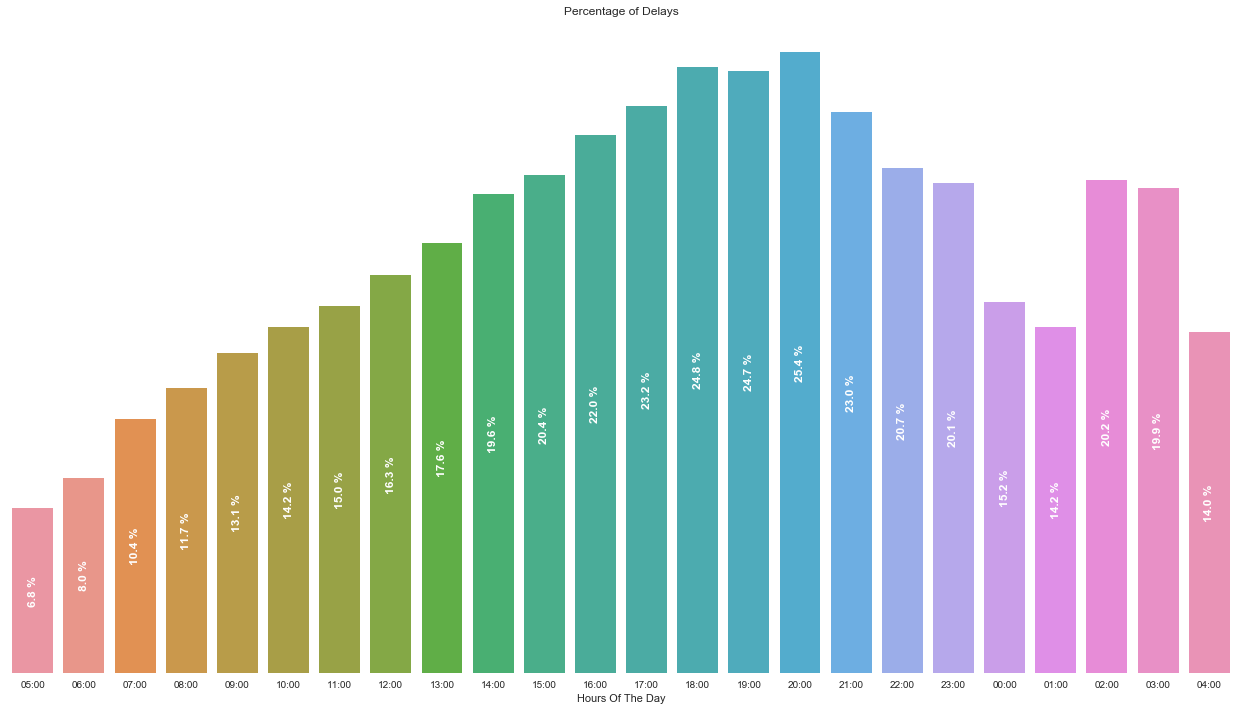

In [13]:
fig, ax = plt.subplots(1,1, figsize=(22,12))
order=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4]
order_labels=["05:00", "06:00", "07:00", "08:00", "09:00", "10:00", "11:00", "12:00", "13:00", 
              "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", 
              "23:00", "00:00", "01:00", "02:00", "03:00", "04:00"]
sns.barplot(x=delay_by_hour.index, y=delay_by_hour["percent"], order=order)
# Annotations
for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, (p.get_height()/2), "{0} %".format(round(p.get_height(),1)), 
                color="w", fontweight="bold", ha="center", va="center", alpha=1, rotation="vertical")
ax.tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
ax.set_yticks([]) #show only the extreme value
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("Hours Of The Day") #x label
ax.set_xticklabels(order_labels)
ax.set_title("Percentage of Delays")
sns.despine(left=True, bottom=True)

fig.savefig("HourOfDay_delays.png", transparent=True, bbox_inches='tight', pad_inches=0)

**The delays increase as the day progresses. The late arrival of the incoming aircraft (or connecting flight/crew/cargo) seems to explain why you are more likely to be delayed if you fly later in the day rather than in the morning.**

## Monthly Analysis
### Delay By Month

In [14]:
delay_by_month = delay.groupby(by="MONTH")["ARR_DEL15"].agg(["sum", "count"])
delay_by_month.loc[:,"percent"] = (delay_by_month["sum"] * 100) / delay_by_month["count"]

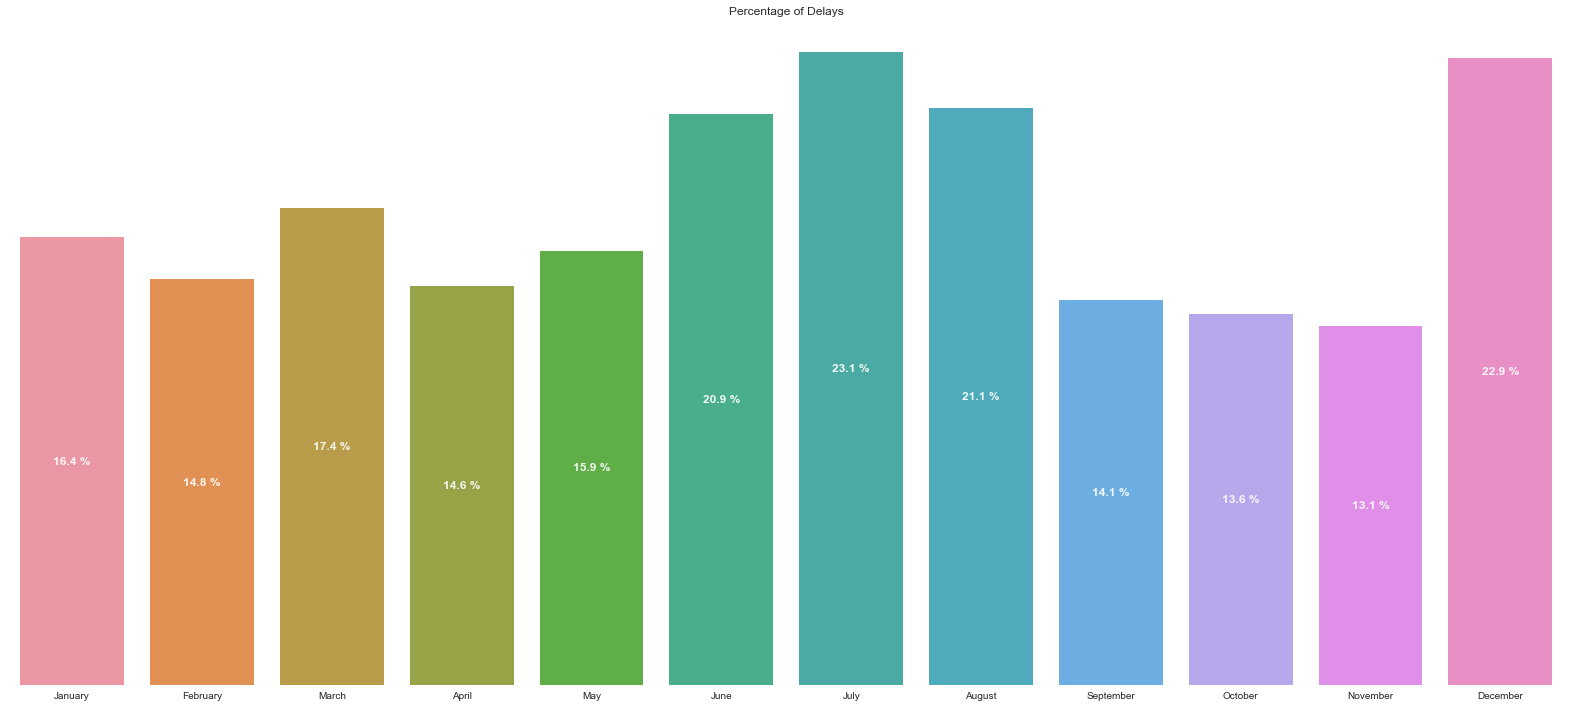

In [15]:
fig, ax = plt.subplots(1,1, figsize=(22,10))
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
         'September', 'October', 'November', 'December']
sns.barplot(x=delay_by_month.index, y=delay_by_month["percent"], ax=ax)

# Annotations
for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, (p.get_height()/2), "{0} %".format(round(p.get_height(),1)), 
                color="w", fontweight="bold", ha="center", va="center", alpha=0.9)
ax.tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
ax.set_yticks([]) #show only the extreme value
ax.set_xticklabels(month)
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("") #x label
ax.set_title("Percentage of Delays")

sns.despine(left=True, bottom=True)
plt.tight_layout()

fig.savefig("Month_delays.png", transparent=True, bbox_inches='tight', pad_inches=0)

**The percentage of delays are higher in summer (June-August) and during the Christmas holidays (December) when the number of travelers is higher.**

### Delays Per Day of Week For Each Month

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Text yticklabel objects>)

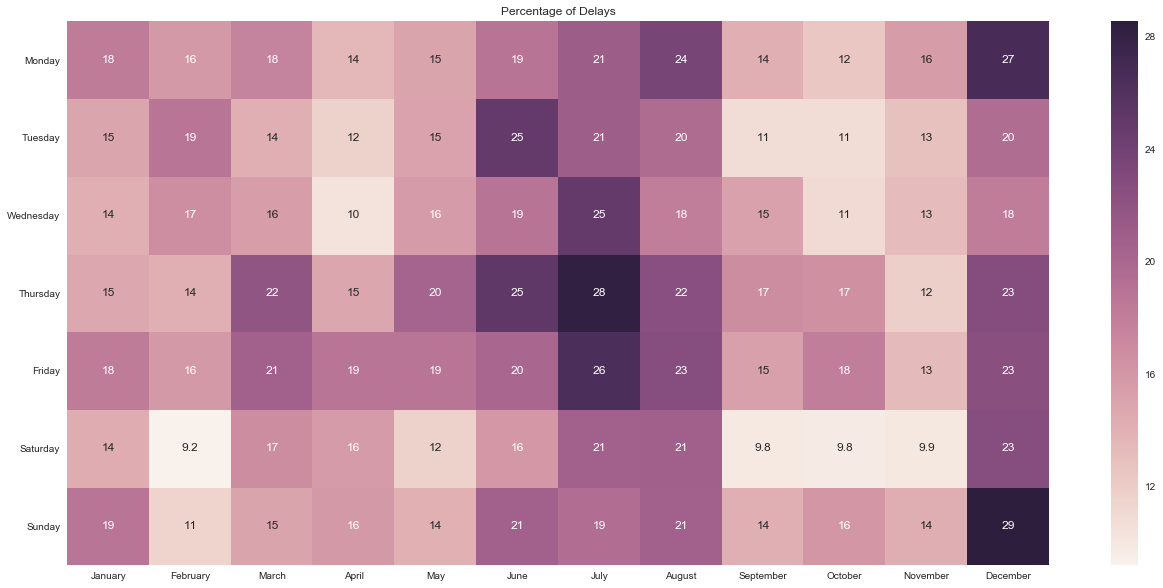

In [16]:
delay_by_md = pd.pivot_table(delay, index="DAY_OF_WEEK", columns="MONTH", values="ARR_DEL15", 
                             aggfunc=lambda x: (np.sum(x) * 100) / len(x))

fig, ax = plt.subplots(1,1, figsize=(22,10))
sns.heatmap(delay_by_md, annot=True, xticklabels=month, yticklabels=days)
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("") #x label
ax.set_title("Percentage of Delays") #title
plt.yticks(rotation=0)

**On average, the worst days to travel were Thursdays and Fridays in July, and Sundays and Mondays in December.**

## Carrier Analysis

In [17]:
carrier_delay_by_month = pd.pivot_table(delay, index="UNIQUE_CARRIER", columns="MONTH", values="ARR_DEL15", 
                                        aggfunc=lambda x: (np.sum(x) * 100) / len(x))
carrier_delay_by_day = pd.pivot_table(delay, index="UNIQUE_CARRIER", columns="DAY_OF_WEEK", values="ARR_DEL15", 
                                      aggfunc=lambda x: (np.sum(x) * 100) / len(x))
carrier_delay = pd.pivot_table(delay, index="UNIQUE_CARRIER", values="ARR_DEL15", 
                                        aggfunc=lambda x: (np.sum(x) * 100) / len(x))
carrier_delay = carrier_delay.reindex(carrier_delay.sort_values(by="ARR_DEL15", ascending=True).index)

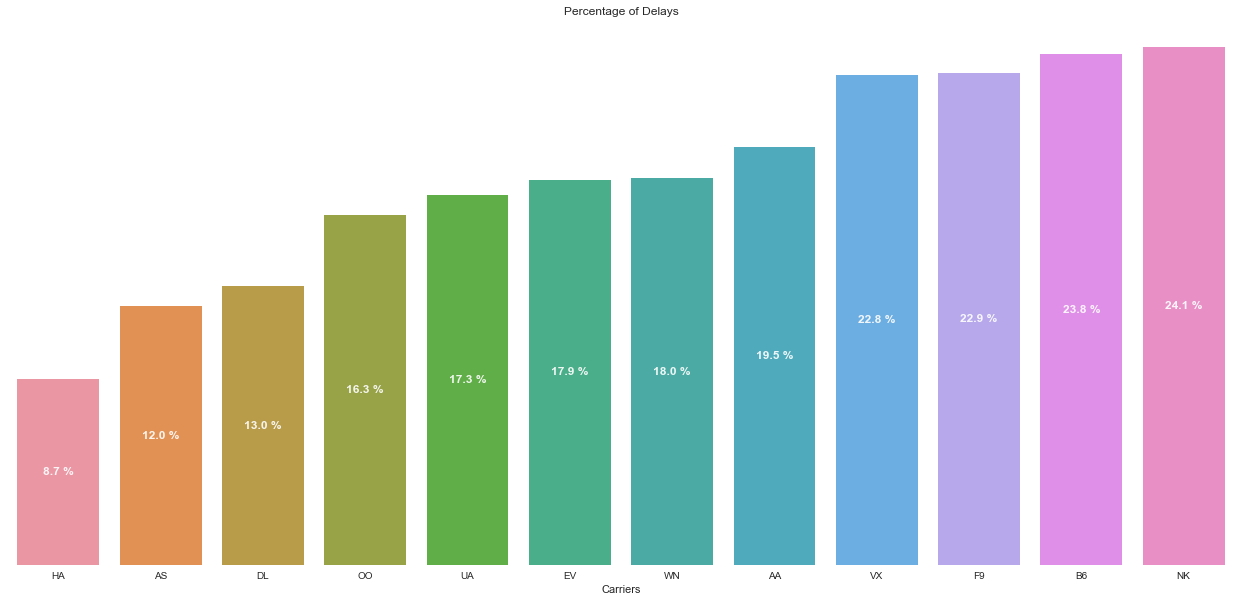

In [18]:
fig, ax = plt.subplots(1,1, figsize=(22,10))
sns.barplot(x=carrier_delay["ARR_DEL15"].index, y=carrier_delay["ARR_DEL15"].values)
# Annotations
for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, (p.get_height()/2), "{0} %".format(round(p.get_height(),1)), 
                color="w", fontweight="bold", ha="center", va="center", alpha=0.9)
ax.tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
ax.set_yticks([]) #show only the extreme value
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("Carriers") #x label
ax.set_title("Percentage of Delays") #title
sns.despine(left=True, bottom=True)

fig.savefig("carrier_delays.png", transparent=True, bbox_inches='tight', pad_inches=0)

**The three best airlines with regard to delays are Hawaiian Airlines Inc. (HA), Alaska Airlines Inc. (AS) and Delta Air Lines Inc. (DL). The worst are Frontier Airlines Inc. (F9), JetBlue Airways (B6) and Spirit Air Lines (NK).**

### Delay Per Carrier For Each Month

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5]), <a list of 12 Text yticklabel objects>)

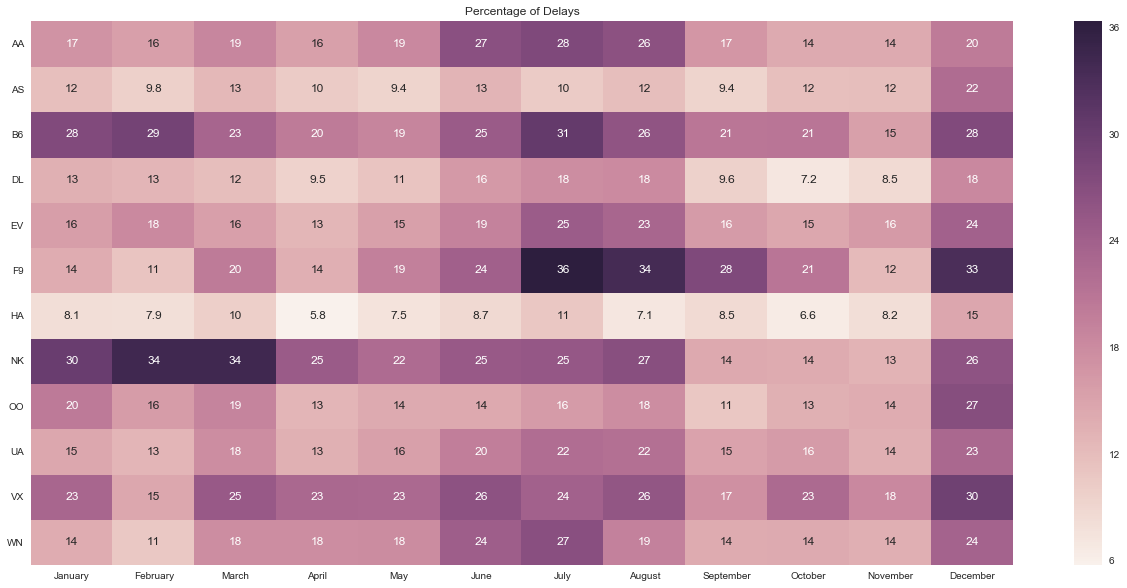

In [19]:
fig, ax = plt.subplots(1,1, figsize=(22,10))
sns.heatmap(carrier_delay_by_month, annot=True, xticklabels=month)
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("") #x label
ax.set_title("Percentage of Delays") #title
plt.yticks(rotation=0)

### Delay Per Carrier For Day

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5]), <a list of 12 Text yticklabel objects>)

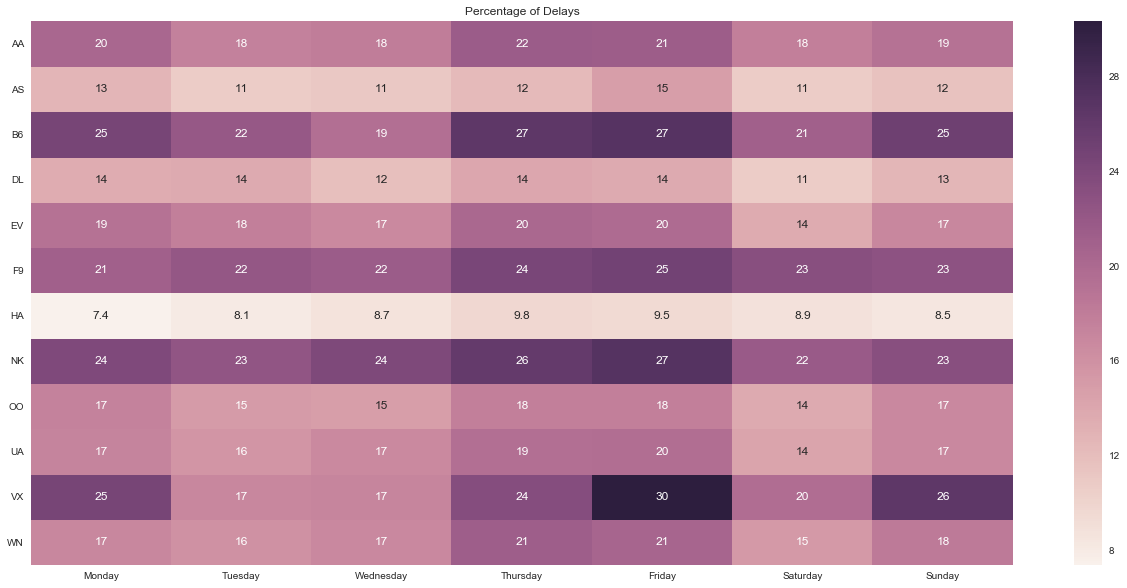

In [20]:
fig, ax = plt.subplots(1,1, figsize=(22,10))
sns.heatmap(carrier_delay_by_day, annot=True, xticklabels=days)
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("") #x label
ax.set_title("Percentage of Delays") #title
plt.yticks(rotation=0)

## Delays by Distance

In [21]:
dist_delay = delay.groupby("DISTANCE_GROUP")["ARR_DEL15"].agg(lambda x: (np.sum(x) * 100) / len(x))

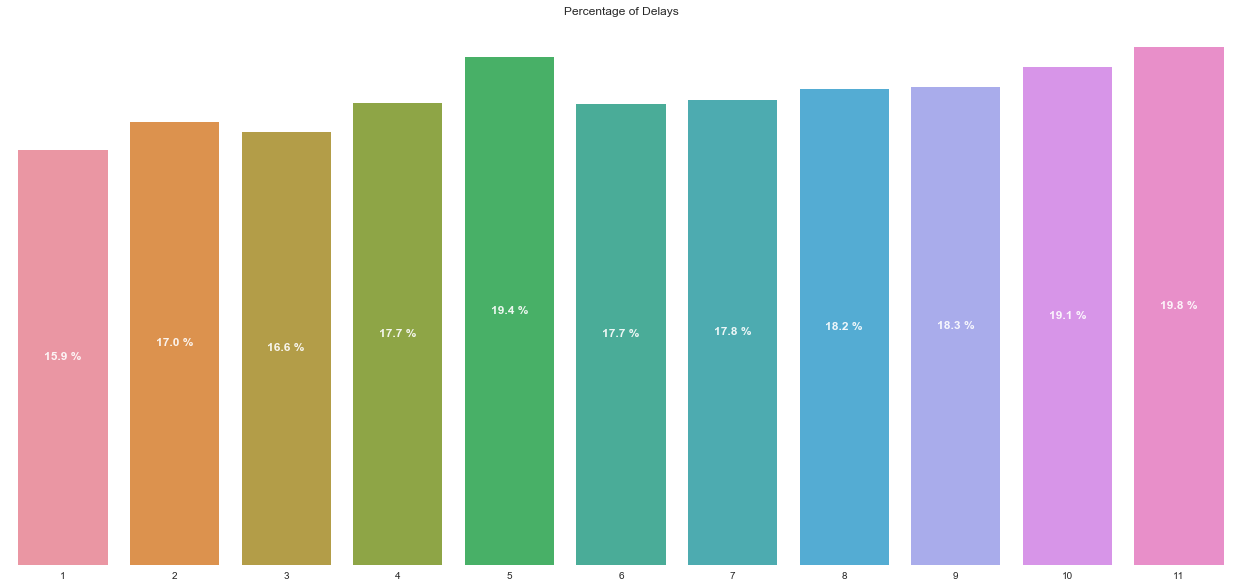

In [22]:
fig, ax = plt.subplots(1,1, figsize=(22,10))
sns.barplot(x=dist_delay.index, y=dist_delay.values)
# Annotations
for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, (p.get_height()/2), "{0} %".format(round(p.get_height(),1)), 
                color="w", fontweight="bold", ha="center", va="center", alpha=0.9)
ax.tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
ax.set_yticks([]) #show only the extreme value
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("") #x label
ax.set_title("Percentage of Delays") #title
sns.despine(left=True, bottom=True)

**The delays tend to be positively correlated with distance.**

## Delays by Airports

In [23]:
dest_delay = delay.groupby("ORIGIN")["ARR_DEL15"].agg(["sum", "count"])
dest_delay.loc[:, "percent"] = (dest_delay["sum"] * 100) / dest_delay["count"]
dest_delay = dest_delay.reindex(dest_delay.sort_values(by="percent", ascending=True).index)

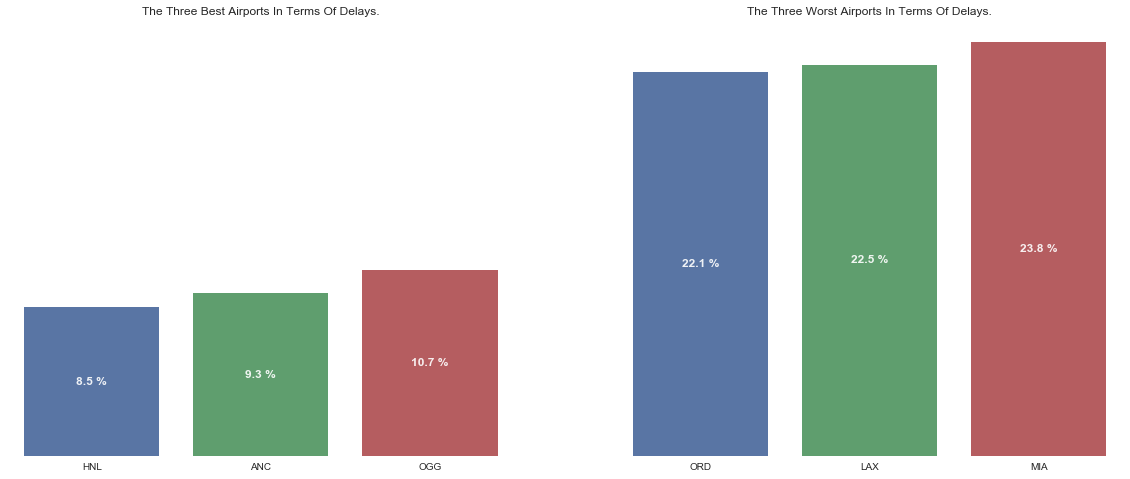

In [24]:
fig, axes = plt.subplots(1,2, figsize=(20,8), sharey=True)
v = dest_delay[dest_delay["count"] > 15000]
sns.barplot(x=v.index[0:3], y=v[0:3]["percent"], ax=axes[0])
sns.barplot(x=v.index[-3:], y=v[-3:]["percent"], ax=axes[1])

# Annotations
for ax in axes:
    for p in ax.patches:
            ax.text(p.get_x()+p.get_width()/2, (p.get_height()/2), "{0} %".format(round(p.get_height(),1)), 
                    color="w", fontweight="bold", ha="center", va="center", alpha=0.9)
    ax.tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
    ax.set_yticks([]) #show only the extreme value
    ax.set_ylabel("") #hiding the "count" label
    ax.set_xlabel("") #x label

axes[0].set_title("The Three Best Airports In Terms Of Delays.") #title plt 1
axes[1].set_title("The Three Worst Airports In Terms Of Delays.") #title plt 2


sns.despine(left=True, bottom=True)

fig.savefig("airports_delays.png", transparent=True, bbox_inches='tight', pad_inches=0)

**The worst airports are Chicago O'Hare Airport (ORD), Los Angeles International Airport (LAX) and Miami International Airport (MIA). They tend to act as hubs for main carriers too. The small airport seems to better perform, Honolulu International Airport, Ted Stevens Anchorage International Airport, Kahului Airport are the best airports in term of delays.**

# The Fastest Flights

In [25]:
def toMinute(x):
    x = str(x)
    if len(x) == 4:
        return int(x[:2]) * 60 + int(x[2:]) 
    if len(x) == 3:
        return int(x[:1]) * 60 + int(x[2:])
    else:
        return int(x)

In [26]:
# Convert departure time to minutes
delay["DEP_TIME_MIN"] = delay["DEP_TIME"].apply(toMinute)
delay["CRS_DEP_TIME_MIN"] = delay["CRS_DEP_TIME"].apply(toMinute)

In [27]:
# Convert arrival time to minutes
delay["ARR_TIME_MIN"] = delay["ARR_TIME"].apply(toMinute)
delay["CRS_ARR_TIME_MIN"] = delay["CRS_ARR_TIME"].apply(toMinute)

In [28]:
# The flights duration in minute
delay["FLIGHTS_DURATION"] = (delay["ARR_TIME_MIN"] - delay["DEP_TIME_MIN"])
delay["CRS_FLIGHTS_DURATION"] = (delay["CRS_ARR_TIME_MIN"] - delay["CRS_DEP_TIME_MIN"])

In [29]:
# Little trick to manage Day +1
fld = (delay["FLIGHTS_DURATION"] <= 0)
delay.loc[fld, "FLIGHTS_DURATION"] = delay.loc[fld, "FLIGHTS_DURATION"].apply(lambda x: x + 1440)
fld = (delay["CRS_FLIGHTS_DURATION"] <= 0)
delay.loc[fld, "CRS_FLIGHTS_DURATION"] = delay.loc[fld, "CRS_FLIGHTS_DURATION"].apply(lambda x: x + 1440)

### Flights Performance

The idea is to compare the airline against the others airlines for a specific route. So we compute the average duration of the carrier A for a route and compare to the average duration of all the carrier for the same route. Finally, we exclude the route with less than 3 carriers and we use the actual duration of a flight (not the CRS).

In [30]:
# Decimal to time
def decTime(d):
    minutes = abs(int(d))
    seconds = int((abs(d)*60) % 60)
    if d > 0:
        return "{:02d}:{:02d}".format(minutes, seconds)
    else:
        return "({:02d}:{:02d})".format(minutes, seconds)

In [31]:
# Reshape the data
flights_perf = delay.pivot_table(index=["ORIGIN", "DEST"], columns="UNIQUE_CARRIER", values="FLIGHTS_DURATION", aggfunc="mean")
# thresh = 3 exclude route where the number of carrier is less than 3
flights_perf = flights_perf.dropna(axis=0, thresh=3)

In [32]:
# Compute the route average (ORIGIN, DEST)
average = flights_perf.mean(axis=1, skipna=True)

In [33]:
flights_perf = flights_perf.subtract(average, axis=0)

# Compute the mean for each carrier
flights_perf = flights_perf.mean(axis=0)
flights_perf = pd.DataFrame(index=flights_perf.index.values, data=flights_perf.values)

# sort the values
flights_perf = flights_perf[0].sort_values(ascending=True)

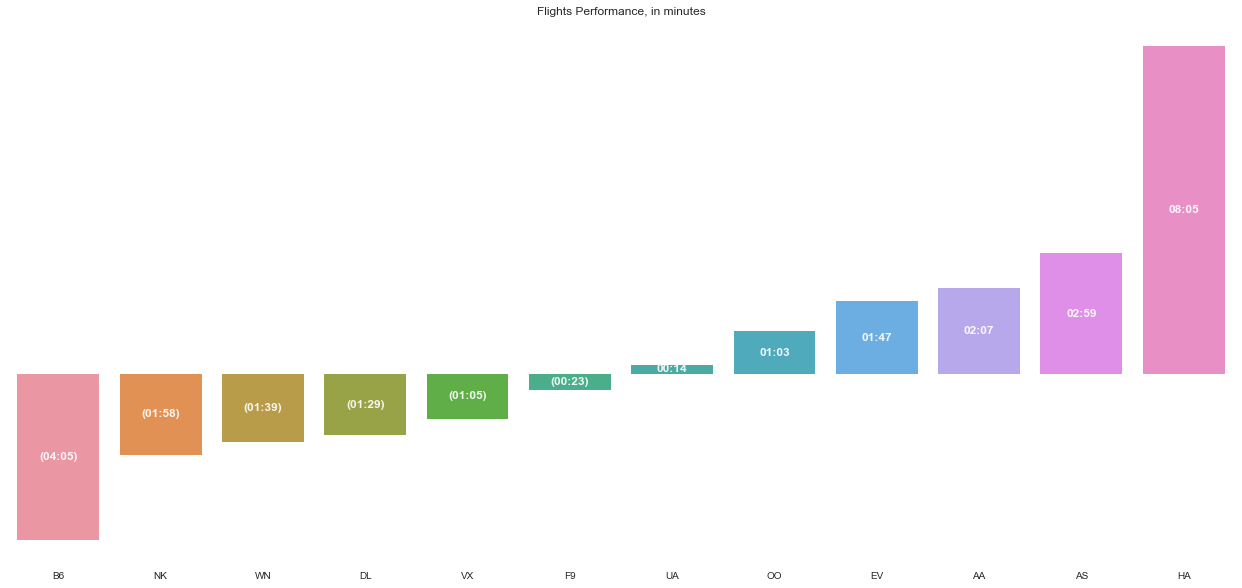

In [34]:
fig, ax = plt.subplots(1,1, figsize=(22,10))
sns.barplot(x=flights_perf.index, y=flights_perf.values)

# Annotations
for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, (p.get_height()/2), decTime(p.get_height()), 
                color="w", fontweight="bold", ha="center", va="center", alpha=0.9)
ax.tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
ax.set_yticks([]) #show only the extreme value
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("") #x label
ax.set_title("Flights Performance, in minutes") #title

sns.despine(left=True, bottom=True)

fig.savefig("fpcarrier_delays.png", transparent=True, bbox_inches='tight', pad_inches=0)

_The top 10 : JetBlue Airways (B6), Spirit Air Lines (NK), Southwest Airlines Co (WN), Delta Air Lines Inc (DL), Virgin America(VX), Frontier Airlines Inc (F9), United Air Lines Inc (UA), SkyWest Airlines Inc. (OO), ExpressJet Airlines Inc. (EV), American Airlines Inc. (AA), Alaska Airlines Inc. (AS), HA: Hawaiian Airlines Inc. (HA)_

### Flights Performance

In a similar way, to have a better view on airlines strategy we compare scheduled times of flight.

In [35]:
# Reshape the data
crs_flights_perf = delay.pivot_table(index=["ORIGIN", "DEST"], columns="UNIQUE_CARRIER", values="CRS_FLIGHTS_DURATION", aggfunc="mean")
# thresh = 3 exclude route where the number of carrier is less than 3
crs_flights_perf = crs_flights_perf.dropna(axis=0, thresh=3)

In [36]:
# Compute the route average (ORIGIN, DEST)
average = crs_flights_perf.mean(axis=1, skipna=True)

In [37]:
crs_flights_perf = crs_flights_perf.subtract(average, axis=0)

# Compute the mean for each carrier
crs_flights_perf = crs_flights_perf.mean(axis=0)
crs_flights_perf = pd.DataFrame(index=crs_flights_perf.index.values, data=crs_flights_perf.values)

# sort the values
crs_flights_perf = crs_flights_perf[0].sort_values(ascending=True)

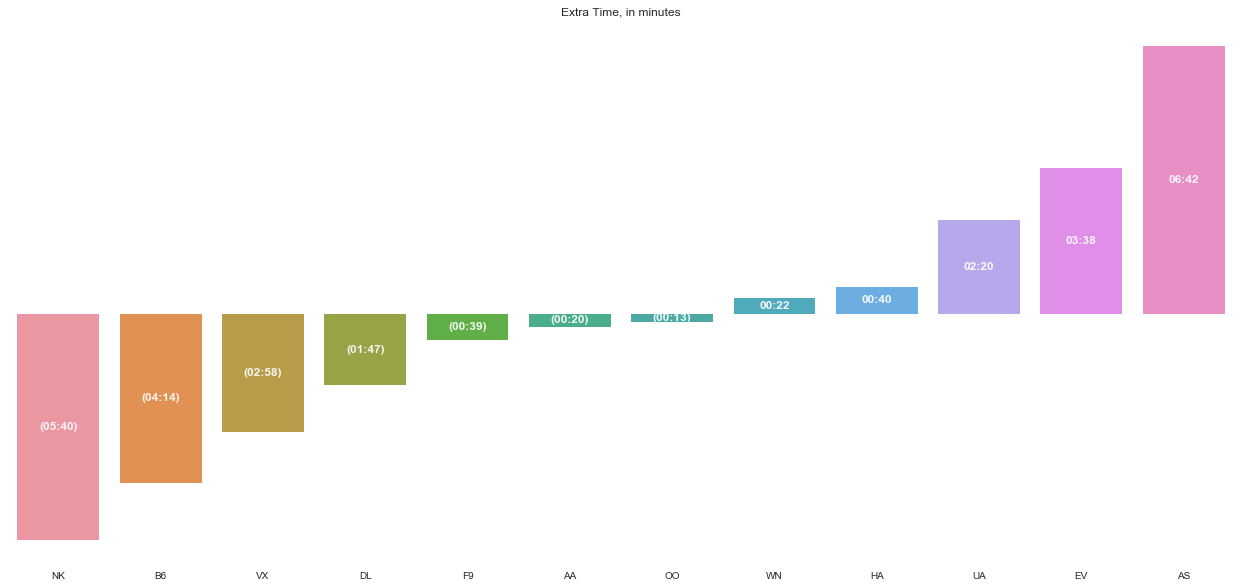

In [38]:
fig, ax = plt.subplots(1,1, figsize=(22,10))
sns.barplot(x=crs_flights_perf.index, y=crs_flights_perf.values)

# Annotations
for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, (p.get_height()/2), decTime(p.get_height()), 
                color="w", fontweight="bold", ha="center", va="center", alpha=0.9)
ax.tick_params(bottom="off", top="off", left="off", right="off") #Hiding Tick Marks
ax.set_yticks([]) #show only the extreme value
ax.set_ylabel("") #hiding the "count" label
ax.set_xlabel("") #x label
ax.set_title("Extra Time, in minutes") #title

sns.despine(left=True, bottom=True)

fig.savefig("schedule_carrier_delays.png", transparent=True, bbox_inches='tight', pad_inches=0)

**We could describe three groups of carrier : the first one fix tighter flight duration (NK, B6, VX, and DL), the second group is very close to the average scheduled time duration (F9, AA, OO, WN, HA), and finally the last one fix larger flight length (UA, EV, and AS).**

### Indicators Analysis

Now, we are ranking airlines by the different indicators and try to see patterns.
<img src="fd-tableau-comparaison.png" />

- **We could see that the three carriers that on average fix larger flight length (United Airlines, ExpressJet Airlines, and Alaska Airlines) have great performance on flight delays but if Alaska Airlines perform poorly in our flight performance computation, the other two have a low average in flight performance. It seems that they choose to exaggerate flight times to avoid flight delays.**
- **Alaska Airlines seems to schedule larger flight duration to achieve fuel economies: the company decide to fly slower to use less fuel and save money (his flight performance are in the line of his extra time). It's might be also the case for Hawaiian Airlines.**
- **In the other hand, airlines with tight schedules times perform better in our flight performance computation than in flight delays. An explanation could be that they choose to have tight schedule to make more rotation with their airplanes and so make more money. In addition, Airlines may have more customers with this strategy, because customers prefer to travel faster, they might select the company with the shortest scheduled time. Even if they face a higher risk of delays.**
- **In this analysis, we find that Delta Airlines is the best carrier, the airline works well on the three rankings.**